<a href="https://colab.research.google.com/github/microprediction/automl-notebooks/blob/main/univariate_autosklearn_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall numpy -y

Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Successfully uninstalled numpy-1.21.6


In [ ]:
!pip install auto-sklearn
!pip install --upgrade pandas 

In [1]:
import pandas as pd 
import numpy as np 
from pprint import pprint
import sklearn.metrics
import autosklearn.regression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from pprint import pprint

# Data to fit 

In [2]:
url = 'https://github.com/microprediction/schooled/blob/main/localoutput/sarima/output/massaged.csv?raw=true'
df = pd.read_csv(url)
df.rename(inplace=True,columns={'y_next':'x'})

In [46]:
num_lags = 20
x_cols = sorted([ c for c in df.columns if 'y_' in c ])[-num_lags:]
y = (df['p1']- df['y_last']).values
X = df[x_cols].values

In [47]:
X = X.astype(np.float32)
n_test = 5000
n_train = len(df)-2*n_test
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:(n_train+n_test)], y[n_train:(n_train+n_test)]
X_val, y_val = X[(n_train+n_test):], y[(n_train+n_test):]


scales = np.logspace(start=0.01, stop=2.0, num=50)
X_copies = [ sc*X_train for sc in scales ]
y_copies = [ sc*y_train for sc in scales ]
X_rep = np.concatenate(X_copies, axis=0)
y_rep = np.concatenate(y_copies, axis=0)

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="./whatever",
)
automl.fit(X_train, y_train, dataset_name="sarima")

[WARNING] [2022-10-28 02:29:32,815:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-10-28 02:30:03,991:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='./whatever')

In [44]:
print(automl.leaderboard())

          rank  ensemble_weight            type      cost   duration
model_id                                                            
4            1             0.92  ard_regression  0.150931   5.035277
6            2             0.08             mlp  0.155424  25.223290


In [50]:
train_predictions = automl.predict(X_train)
test_predictions = automl.predict(X_test)
val_predictions = automl.predict(X_val)

print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print("Test R2 score:", sklearn.metrics.r2_score(y_val, val_predictions))
print("Train MSE score:", sklearn.metrics.mean_squared_error(y_train, train_predictions))
print("Test MSE score:", sklearn.metrics.mean_squared_error(y_test, test_predictions))
print("Val MSE score:", sklearn.metrics.mean_squared_error(y_val, val_predictions))
print('Val MSE relative to last value:',sklearn.metrics.mean_squared_error(y_val, val_predictions)/sklearn.metrics.mean_squared_error(y_val, np.zeros_like(y_val)))


Train R2 score: 0.8584852612130593
Test R2 score: 0.843011007512966
Test R2 score: 0.8385386313359304
Train MSE score: 0.0007177378413273061
Test MSE score: 0.0008462032306309375
Val MSE score: 0.0008138129115790806
Val MSE relative to last value: 0.16145091345537432


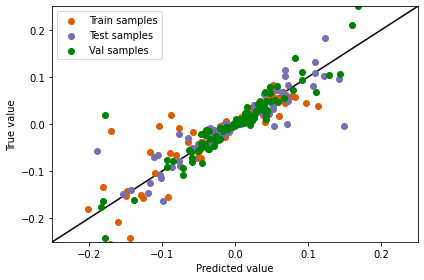

In [48]:
import matplotlib.pyplot as plt
some = 100
plt.scatter(train_predictions[:some], y_train[:some], label="Train samples", c="#d95f02")
plt.scatter(test_predictions[:some], y_test[:some], label="Test samples", c="#7570b3")
plt.scatter(val_predictions[:some], y_val[:some], label="Val samples", c="green")
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([-0.25, 0.25], [-0.25, 0.25], c="k", zorder=0)
plt.xlim([-0.25, 0.25])
plt.ylim([-0.25, 0.25])
plt.tight_layout()
plt.show()

### MLP

In [59]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
regr = MLPRegressor(random_state=1, max_iter=50000, activation='tanh',
                    hidden_layer_sizes=(50,50,50,50,50,50)).fit(X_train, y_train)

train_predictions = regr.predict(X_train)
test_predictions = regr.predict(X_test)
val_predictions = regr.predict(X_val)

print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print("Test R2 score:", sklearn.metrics.r2_score(y_val, val_predictions))
print("Train MSE score:", sklearn.metrics.mean_squared_error(y_train, train_predictions))
print("Test MSE score:", sklearn.metrics.mean_squared_error(y_test, test_predictions))
print("Val MSE score:", sklearn.metrics.mean_squared_error(y_val, val_predictions))
print('Val MSE relative to last value:',sklearn.metrics.mean_squared_error(y_val, val_predictions)/sklearn.metrics.mean_squared_error(y_val, np.zeros_like(y_val)))


Train R2 score: 0.8249426383493642
Test R2 score: 0.8184281399242912
Test R2 score: 0.8151273891311552
Train MSE score: 0.0008878601192823298
Test MSE score: 0.0009787099856725515
Val MSE score: 0.0009318124760568894
Val MSE relative to last value: 0.18486063969738334
